In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ukb_gwas import *
from scipy import stats

In [2]:
# getting standard snp set for EDUYEARS = Lee et al.
eduyears_lead_snps = pd.read_excel('41588_2018_147_MOESM3_ESM.xlsx', 
                                  sheet_name = '2. EduYears Lead SNPs',
                                  skipfooter = 2, header = 1, index_col = None )
eduyears_snplist = eduyears_lead_snps.SNP.tolist()
print(len(eduyears_snplist))
print(eduyears_snplist[:5])

1271
['rs9859556', 'rs7029718', 'rs1334297', 'rs9375188', 'rs2526398']


In [23]:
# getting standard snp set for BMI
bmi_giant = pd.read_csv('Locke_GIANT_bmi_snps.txt',delimiter = '\t')
bmi_snplist = bmi_giant.SNP.tolist()
print(len(bmi_snplist))
print(bmi_snplist[:5])

941
['rs1000096', 'rs1000940', 'rs1003081', 'rs10035289', 'rs10037047']


In [3]:
# need to get the chromosomes for each of these snps
# first, load the data (probably a better way to do this)
fstem = 'chr'
fdir = 'mover_status/'
onePositions, oneVariants, onePvals, oneBetas, oneErrors = load_chromosomes(fstem,fdir)

mover_status/chr1.all.glm.logistic
done loading chromosomes


In [4]:
# getting standard snp set for HEIGHT
height_giant = pd.read_csv('giant_locke_2018_height_snps.txt',delimiter = '\t')
height_snplist = height_giant.SNP.tolist()
print(len(height_snplist))
print(height_snplist[:5])

3290
['rs10003497', 'rs1000410', 'rs10008015', 'rs10010325', 'rs10016290']


In [4]:
snplist = eduyears_snplist
chroms_for_snps = {}
for chrom in oneVariants.keys():
    snps_on_chromosome = list(set(oneVariants[chrom])&set(snplist))
    for snp in snps_on_chromosome:
        chroms_for_snps[snp] = chrom

In [6]:
print(chroms_for_snps['rs9859556'])

3


In [25]:
with open('bmi_giant_snps.txt','w') as o:
    for snp in chroms_for_snps.keys():
        o.write(snp + ' ' + str(chroms_for_snps[snp]) + '\n')
# scp bmi_giant_snps.txt igw9@cbsulogin.tc.cornell.edu:/bscb/bscb09/500k_ukb/ian/gwas_files/.

In [8]:
with open('eduyears_lee_snps.txt','w') as o:
    for snp in chroms_for_snps.keys():
        o.write(snp + ' ' + str(chroms_for_snps[snp]) + '\n')

In [7]:
# make header and add to files
#chrom snp ref alt hom_ref het hom_alt hap_ref hap_alt missing
# load in as a dataframe
mover_counts = pd.read_csv('mover_genotype_counts.txt',delimiter = '\t')
stayer_counts = pd.read_csv('stayer_genotype_counts.txt',delimiter = '\t')
# mover_counts  = pd.read_csv('mover_genotype_counts_rarefied.txt',delimiter = '\t')
# stayer_counts = pd.read_csv('stayer_genotype_counts_rarefied.txt',delimiter = '\t')
# mover_counts  = pd.read_csv('height_giant_movers.txt',delimiter = '\t')
# stayer_counts = pd.read_csv('height_giant_stayers.txt',delimiter = '\t')
# mover_counts  = pd.read_csv('bmi_giant_movers.txt',delimiter = '\t')
# stayer_counts = pd.read_csv('bmi_giant_stayers.txt',delimiter = '\t')
print(len(stayer_counts))
stayer_counts.head(10)

1251


,chrom,snp,ref,alt,hom_ref,het,hom_alt,hap_ref,hap_alt,missing
0,5,rs27220,A,G,24121,81958,70794,0,0,242
1,6,rs35104491,A,G,6182,53969,116246,0,0,718
2,4,rs9683585,G,C,34701,86652,54331,0,0,1431
3,2,rs17428076,G,C,10458,64408,101868,0,0,381
4,11,rs12574281,C,A,25301,81909,67185,0,0,2720
5,2,rs1527878,A,G,101433,63062,10000,0,0,2620
6,9,rs4877516,T,A,53174,87439,35635,0,0,867
7,9,rs2805064,G,C,13811,70761,90610,0,0,1933
8,5,rs981230,T,C,37921,87695,50485,0,0,1014
9,8,rs1485300,C,G,74782,76404,19288,0,0,6641


In [8]:
moversnps = mover_counts.snp.tolist()
stayersnps = stayer_counts.snp.tolist()
print(len(moversnps))
print(len(stayersnps))
snps = list(set(moversnps)&set(stayersnps))

genotype_chis = []
genotype_pvals = []

allele_chis = []
allele_pvals = []

m_hwe_pvals = []
s_hwe_pvals = []

#snps = ['rs35104491','rs981230']
for snp in snps:
    mrow = mover_counts[mover_counts.snp==snp]
    srow = stayer_counts[stayer_counts.snp==snp]
    if mrow.ref.values[0] == srow.ref.values[0]:
    
        # genotype counts
        m = mrow[['hom_ref','het','hom_alt']].values
        s = srow[['hom_ref','het','hom_alt']].values
        cont_table = np.vstack([m,s])
        #print(cont_table)
        geno_chisq,geno_pval,dof,exp = stats.chi2_contingency(cont_table)
        #print(chisq,pval,dof)
        
        genotype_chis.append(geno_chisq)
        genotype_pvals.append(geno_pval)
        
        # allele counts
        ma1 = 2*m[0][0] + m[0][1]
        ma2 = m[0][1] + 2*m[0][2]
        sa1 = 2*s[0][0] + s[0][1]
        sa2 = s[0][1] + 2*s[0][2]
        
        m_allele_counts = np.array([ma1,ma2])
        s_allele_counts = np.array([sa1,sa2])
        allele_cont_table = np.vstack([m_allele_counts,s_allele_counts])
        #print(allele_cont_table)
        
        allele_chisq,allele_pval,dof,exp = stats.chi2_contingency(allele_cont_table)
        #print(allele_chisq,allele_pval,dof)
        allele_chis.append(allele_chisq)
        allele_pvals.append(allele_pval)
        
        # HWE goodness of fit
        m_total_alleles = float(ma1 + ma2)
        m_total_individuals = np.sum(m[0])
        m_p = ma1 / m_total_alleles
        m_q = ma2 / m_total_alleles
        m_exp = [m_p**2 * m_total_individuals, 2 * m_p * m_q * m_total_individuals, m_q**2 * m_total_individuals]
        chisq_hwe_m, pval_hwe_m = stats.chisquare(m[0],m_exp)
        m_hwe_pvals.append(pval_hwe_m)

        s_total_alleles = float(sa1 + sa2)
        s_total_individuals = np.sum(s[0])
        s_p = sa1 / s_total_alleles
        s_q = sa2 / s_total_alleles
        s_exp = [s_p**2 * s_total_individuals, 2 * s_p * s_q * s_total_individuals, s_q**2 * s_total_individuals]
        chisq_hwe_s, pval_hwe_s = stats.chisquare(s[0],s_exp)
        s_hwe_pvals.append(pval_hwe_s)

    else:
        print('problem for ' + snp)
#     print('chisq:', '{:1.2f}'.format(chisq))
#     print('pval: ', '{:1.2e}'.format(pval))
#     print('dof:  ', dof)

1252
1251


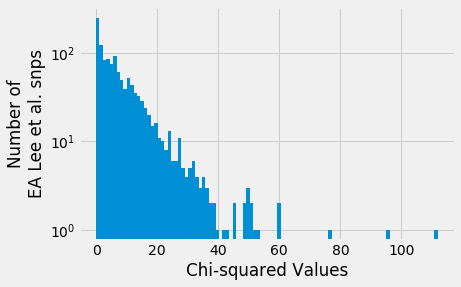

In [9]:
plt.style.use('fivethirtyeight')
plt.hist(allele_chis,100)
plt.yscale('log')
plt.ylabel('Number of\nEA Lee et al. snps')
plt.xlabel('Chi-squared Values')
plt.show()

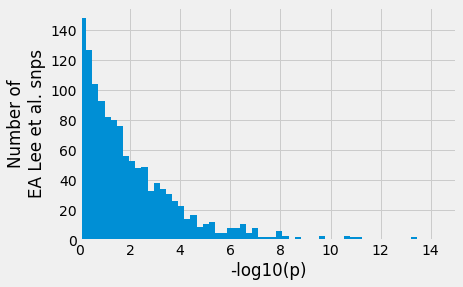

In [10]:
plt.style.use('fivethirtyeight')
plt.hist(-np.log10(genotype_pvals),100)
#plt.yscale('log')
plt.ylabel('Number of\nEA Lee et al. snps')
plt.xlabel('-log10(p)')
plt.xlim([0,15])
plt.show()

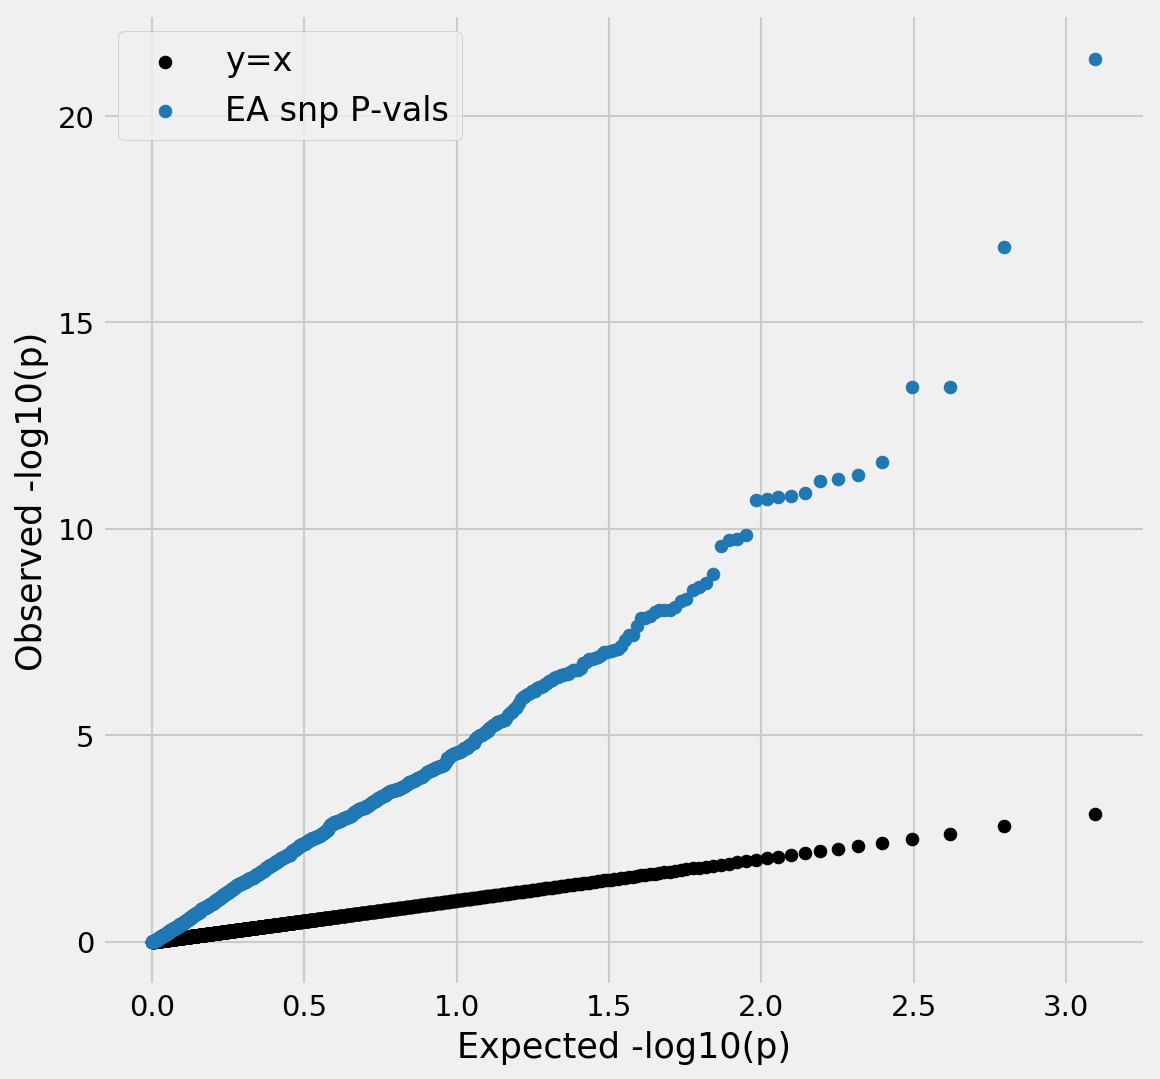

In [13]:
qqplot([genotype_pvals],['EA snp P-vals'])

1251


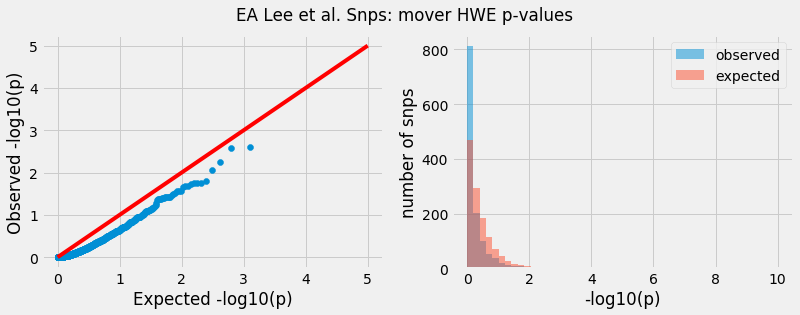

In [57]:
sorted_pvals = sorted(-np.log10(m_hwe_pvals))
print(len(sorted_pvals))
uniform_one = np.linspace(0,1,len(sorted_pvals))
uniform_one = uniform_one[1:] # cannot do log10(0)
sorted_pvals = sorted_pvals[1:]
log_uniform_one = sorted(-np.log10(uniform_one))

f,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))

ax1.scatter(log_uniform_one,sorted_pvals)
#ax1.scatter(log_uniform_one,log_uniform_one)

ax1.plot([0,5],[0,5],'-r')
ax1.set_ylabel('Observed -log10(p)')
ax1.set_xlabel('Expected -log10(p)')

numBins = 50
bins = np.linspace(0, 10, numBins)
ax2.hist(sorted_pvals,bins,alpha = 0.5, label='observed')
ax2.hist(log_uniform_one,bins,alpha = 0.5, label='expected')
ax2.set_xlabel('-log10(p)')
ax2.set_ylabel('number of snps')
ax2.legend()
plt.suptitle('EA Lee et al. Snps: mover HWE p-values')
plt.show()

In [17]:
print(sorted(-np.log10(genotype_pvals),reverse=True)[:5])
print(sorted(-np.log10(allele_pvals),reverse=True)[:5])

[24.489242817738074, 11.589771109910124, 10.865906006655491, 9.612220641075169, 8.554769034483341]
[25.42067913979282, 12.521255628140107, 11.308987749996106, 9.598852386204157, 9.269087268717552]


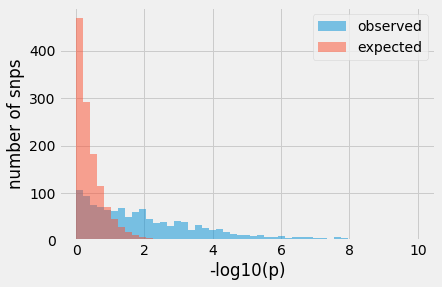

In [24]:
numBins = 50
bins = np.linspace(0, 10, numBins)
plt.hist(sorted_pvals,bins,alpha = 0.5, label='observed')
plt.hist(log_uniform_one,bins,alpha = 0.5, label='expected')
plt.xlabel('-log10(p)')
plt.ylabel('number of snps')
plt.legend()
plt.show()